In [426]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit

In [427]:


import pandas as pd
import numpy as np

from mamimo.time_utils import add_time_features, PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation, BoxCoxSaturation, HillSaturation

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as stats

import holidays

import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataframe

In [428]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'google_impressions', 'tt_impressions'])

In [429]:
# Sum clicks for each channel
df = df.eval('total_clicks = fb_clicks + tt_clicks + google_clicks')
df

,orders,total_sales,facebook,fb_clicks,google,google_clicks,tiktok,tt_clicks,day,total_clicks
Day,,,,,,,,,,
2021-07-01,10,414.85,257.01,129.0,1.17,20.0,0.00,0.0,2021-07-01,149.0
2021-07-02,6,229.95,250.30,150.0,0.84,7.0,0.00,0.0,2021-07-02,157.0
2021-07-03,10,459.89,248.59,129.0,0.72,6.0,0.00,0.0,2021-07-03,135.0
2021-07-04,17,508.36,258.05,119.0,0.07,5.0,0.00,0.0,2021-07-04,124.0
2021-07-05,13,399.88,257.47,142.0,0.38,16.0,0.00,0.0,2021-07-05,158.0
...,...,...,...,...,...,...,...,...,...,...
2023-08-20,294,13616.97,2148.53,1366.0,466.56,801.0,368.86,644.0,2023-08-20,2811.0
2023-08-21,356,15348.42,2210.01,1284.0,400.58,782.0,391.14,494.0,2023-08-21,2560.0
2023-08-22,150,6054.53,1335.84,839.0,289.46,619.0,218.61,398.0,2023-08-22,1856.0


# Split data

In [430]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

y_train = train_df['total_clicks']
X_train = train_df.drop(columns = ['total_sales', 'orders', 'total_clicks', 'fb_clicks', 'google_clicks', 'tt_clicks'])

y_test = test_df['total_clicks']
X_test = test_df.drop(columns = ['total_sales', 'orders', 'total_clicks', 'fb_clicks', 'google_clicks', 'tt_clicks'])

In [431]:
X_train

,facebook,google,tiktok,day
Day,,,,
2021-07-01,257.01,1.17,0.00,2021-07-01
2021-07-02,250.30,0.84,0.00,2021-07-02
2021-07-03,248.59,0.72,0.00,2021-07-03
2021-07-04,258.05,0.07,0.00,2021-07-04
2021-07-05,257.47,0.38,0.00,2021-07-05
...,...,...,...,...
2023-04-12,885.33,208.52,209.03,2023-04-12
2023-04-13,882.17,186.47,208.82,2023-04-13
2023-04-14,662.08,160.69,216.38,2023-04-14


In [432]:
class AddHolidaysTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        de_holiday_list = []
        for holiday in holidays.Germany(years=[2021,2022,2023]).items():
            de_holiday_list.append(holiday)
        de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
        de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
        de_holidays_df.set_index('date', inplace=True)
        
        at_holiday_list = []
        for holiday in holidays.Austria(years=[2021,2022,2023]).items():
            at_holiday_list.append(holiday)
        at_holidays_df = pd.DataFrame(at_holiday_list, columns=["date", "holiday"])
        at_holidays_df['date'] = pd.to_datetime(at_holidays_df['date'])
        at_holidays_df.set_index('date', inplace=True)

        # add DE holidays to df
        merged_df = df.merge(de_holidays_df, how='left', left_index=True, right_index=True)
        merged_df['de_holiday'] = merged_df.index.isin(de_holidays_df.index).astype(int)
        merged_df.drop(columns=['holiday'], inplace=True)
        
        # add AT holidays to df
        at_holidays_df['at_holiday'] = 1 # add a 1 column to austrian holidays dataframe to help us merge with DE holidays
        merged_df = merged_df.merge(at_holidays_df[['at_holiday']], how='left', left_index=True, right_index=True)
        merged_df.head() # creates two columns (at_holiday_x, at_holiday_y), we only need one
        merged_df['at_holiday'].fillna(0, inplace=True) # replace NaN (no holiday) with 0
        merged_df['at_holiday'] = merged_df['at_holiday'].astype(int) # convert 1 and 0 to integers
        
        # combine columns
        merged_df['holiday'] = (merged_df['at_holiday'] | merged_df['de_holiday']).astype(int)
        merged_df = merged_df.drop(columns = ['de_holiday', 'at_holiday']) # drop individual DE and AT rows
        
        return merged_df[['holiday']]#.reset_index(drop=True)


In [433]:
class AddMonthsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df = (df
        .pipe(add_time_features, month=True)
        )
        
        months_in_a_year = 12

        df['sin_MonthYear'] = np.sin(2*np.pi*(df['month'])/months_in_a_year)
        df['cos_MonthYear'] = np.cos(2*np.pi*(df['month'])/months_in_a_year)
        df.drop(columns=['month'], inplace=True)
        
        return df[['sin_MonthYear', 'cos_MonthYear']]

In [434]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

In [435]:
class ReturnChannels(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        return df[['facebook', 'google', 'tiktok']]

# CT

In [436]:

time_features = ColumnTransformer(
    [
     ('holidays_pipe', Pipeline([
            ('add_holidays', AddHolidaysTransformer())
     ]), ['day']),
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day'])
])

"""channel_features = ColumnTransformer(
    [
        ('channel_pipe', Pipeline([
            ('add_channels', ReturnChannels().)
        ]))
    ]
)"""

adstock = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['tiktok'])
])

# Adstock Pipeline

In [437]:
model = LinearRegression()
forest = RandomForestRegressor()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)
enet = ElasticNet()

adstock_pipeline = Pipeline([
    ('adstock', adstock)
])

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

union = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('adstock_pipeline', adstock_pipeline)
])

pipeline = Pipeline([
    ('union', union),
    ('model', model)
])

grid = {
    'enet__alpha': [0.01, 0.1, 0.5, 1], 
    'enet__l1_ratio': [0.2, 0.5, 0.75, 0.8, 0.95]}

param_grid = {'union__adstock_pipeline__adstock1__tiktok_pipe__saturation__shift': [10],
              'union__adstock_pipeline__adstock1__tiktok_pipe__saturation__exponent': [0.8],
              'union__adstock_pipeline__adstock1__tiktok_pipe__carryover__window': [3],
              'union__adstock_pipeline__adstock1__tiktok_pipe__carryover__strength': [0.5],
              'union__adstock_pipeline__adstock1__google_pipe__saturation__shift': [8],
              'union__adstock_pipeline__adstock1__google_pipe__saturation__exponent': [1.1],
              'union__adstock_pipeline__adstock1__google_pipe__carryover__window': [2],
              'union__adstock_pipeline__adstock1__google_pipe__carryover__strength': [1.0],
              'union__adstock_pipeline__adstock1__facebook_pipe__saturation__shift': [7],
              'union__adstock_pipeline__adstock1__facebook_pipe__saturation__exponent': [1.1],
              'union__adstock_pipeline__adstock1__facebook_pipe__carryover__window': [1],
              'union__adstock_pipeline__adstock1__facebook_pipe__carryover__strength': [0.5]}

In [438]:
"""random_search = RandomizedSearchCV(pipeline, param_grid_, n_iter=500, n_jobs = -1, cv = tscv)
random_search.fit(X_train, y_train)
best_pipeline = random_search.best_estimator_

f"R-squared: {best_pipeline.score(X_test, y_test)}"""

'random_search = RandomizedSearchCV(pipeline, param_grid_, n_iter=500, n_jobs = -1, cv = tscv)\nrandom_search.fit(X_train, y_train)\nbest_pipeline = random_search.best_estimator_\n\nf"R-squared: {best_pipeline.score(X_test, y_test)}'

# Linear

In [439]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                   Pipeline(steps=[('add_holidays',
                                                                                                                    AddHolidaysTransformer())]),
                                                                                                   ['day']),
                                                                                                  ('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day'])]))])),
                                                ('adstock_pipeline',
                                                 Pipeline(...
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['facebook']),
                                                                                                  ('google_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['google']),
                                                                                                  ('tiktok_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['tiktok'])]))]))])),
                ('model', LinearRegression())])

In [440]:
pipeline.score(X_test, y_test)

0.5684900285056735

## Pipeline Output

In [441]:
pipe_df = pd.DataFrame(pipeline[0].transform(X_train))
pipe_df.columns = ['holiday','weekend', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df['adstock_sum'] = pipe_df['adstock_fb'] + pipe_df['adstock_gg'] + pipe_df['adstock_tt']
pipe_df['day'] = train_df.index
pipe_df.set_index('day', inplace=True)
pipe_df_2 = pipe_df.copy()
pipe_df_2['total_clicks'] = train_df['total_clicks']
pipe_df_2

,holiday,weekend,adstock_fb,adstock_gg,adstock_tt,adstock_sum,total_clicks
day,,,,,,,
2021-07-01,0.0,0.0,257.01,1.17,0.00,258.18,149.0
2021-07-02,0.0,1.0,250.30,0.84,0.00,251.14,157.0
2021-07-03,0.0,1.0,248.59,0.72,0.00,249.31,135.0
2021-07-04,0.0,0.0,258.05,0.07,0.00,258.12,124.0
2021-07-05,0.0,0.0,257.47,0.38,0.00,257.85,158.0
...,...,...,...,...,...,...,...
2023-04-12,0.0,0.0,885.33,208.52,209.03,1302.88,1430.0
2023-04-13,0.0,0.0,882.17,186.47,208.82,1277.46,1337.0
2023-04-14,0.0,1.0,662.08,160.69,216.38,1039.15,1101.0


## Score

In [442]:
y_pred = pipeline.predict(X_train)
y_true = y_train

rmse = mean_squared_error(y_true, y_pred, squared = False)
mse = mean_squared_error(y_true, y_pred, squared = True)
mae = mean_absolute_error(y_true, y_pred)

f"MAE: {mae}, RMSE: {rmse}, MSE: {mse}"

'MAE: 168.42050953148447, RMSE: 228.31636856270822, MSE: 52128.36415366241'

<Axes: xlabel='adstock_sum', ylabel='total_clicks'>

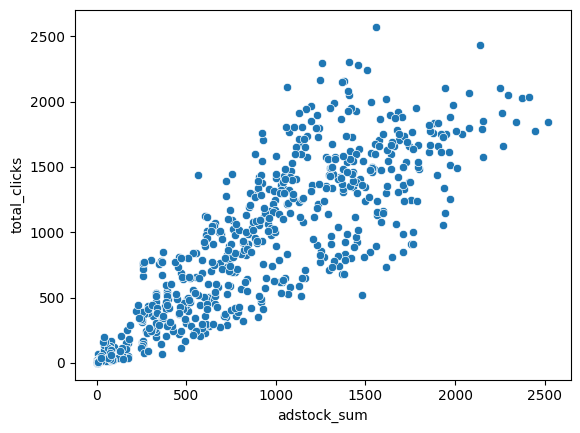

In [443]:
sns.scatterplot(data = pipe_df_2, x = 'adstock_sum', y = 'total_clicks')

# Forest

In [444]:
forest_pipeline = Pipeline([
    ('union', union),
    ('forest', forest)
])

forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                   Pipeline(steps=[('add_holidays',
                                                                                                                    AddHolidaysTransformer())]),
                                                                                                   ['day']),
                                                                                                  ('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day'])]))])),
                                                ('adstock_pipeline',
                                                 Pipeline(...
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['facebook']),
                                                                                                  ('google_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['google']),
                                                                                                  ('tiktok_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['tiktok'])]))]))])),
                ('forest', RandomForestRegressor())])

## Pipeline Output

In [445]:
forest_pipe_df = pd.DataFrame(pipeline[0].transform(X_train))
forest_pipe_df.columns = ['holiday','weekend', 'adstock_fb', 'adstock_gg', 'adstock_tt']
forest_pipe_df['adstock_sum'] = forest_pipe_df['adstock_fb'] + forest_pipe_df['adstock_gg'] + forest_pipe_df['adstock_tt']
forest_pipe_df['day'] = train_df.index
forest_pipe_df.set_index('day', inplace=True)
forest_pipe_df_2 = forest_pipe_df.copy()
forest_pipe_df_2['total_clicks'] = train_df['total_clicks']
forest_pipe_df_2


,holiday,weekend,adstock_fb,adstock_gg,adstock_tt,adstock_sum,total_clicks
day,,,,,,,
2021-07-01,0.0,0.0,257.01,1.17,0.00,258.18,149.0
2021-07-02,0.0,1.0,250.30,0.84,0.00,251.14,157.0
2021-07-03,0.0,1.0,248.59,0.72,0.00,249.31,135.0
2021-07-04,0.0,0.0,258.05,0.07,0.00,258.12,124.0
2021-07-05,0.0,0.0,257.47,0.38,0.00,257.85,158.0
...,...,...,...,...,...,...,...
2023-04-12,0.0,0.0,885.33,208.52,209.03,1302.88,1430.0
2023-04-13,0.0,0.0,882.17,186.47,208.82,1277.46,1337.0
2023-04-14,0.0,1.0,662.08,160.69,216.38,1039.15,1101.0


## Score

In [446]:
y_pred = forest_pipeline.predict(X_train)
y_true = y_train

forest_rmse = mean_squared_error(y_true, y_pred, squared = False)
forest_mse = mean_squared_error(y_true, y_pred, squared = True)
forest_mae = mean_absolute_error(y_true, y_pred)

f"MAE: {forest_mae}, RMSE: {forest_rmse}, MSE: {forest_mse}"

'MAE: 45.88604580152673, RMSE: 66.35790013196367, MSE: 4403.370909923665'

<Axes: xlabel='adstock_sum', ylabel='total_clicks'>

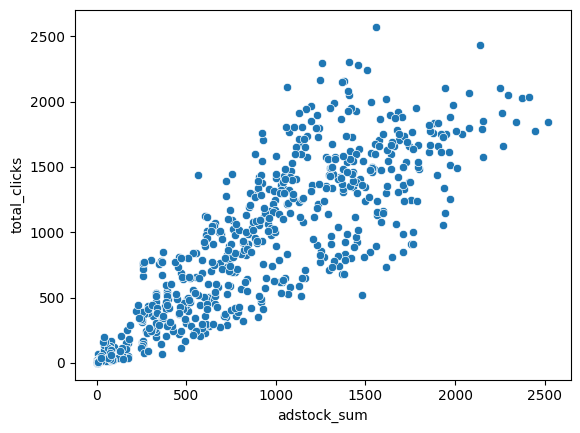

In [447]:
sns.scatterplot(data = forest_pipe_df_2, x = 'adstock_sum', y = 'total_clicks')

# Lasso

In [448]:
lasso_pipeline = Pipeline([
    ('union', union),
    ('lasso', lasso)
])

lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                   Pipeline(steps=[('add_holidays',
                                                                                                                    AddHolidaysTransformer())]),
                                                                                                   ['day']),
                                                                                                  ('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day'])]))])),
                                                ('adstock_pipeline',
                                                 Pipeline(...
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['facebook']),
                                                                                                  ('google_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['google']),
                                                                                                  ('tiktok_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['tiktok'])]))]))])),
                ('lasso', Lasso(alpha=0.1))])

In [449]:
lasso_pipe_df = pd.DataFrame(lasso_pipeline[0].transform(X_train))
lasso_pipe_df.columns = ['holiday','weekend', 'adstock_fb', 'adstock_gg', 'adstock_tt']
lasso_pipe_df['adstock_sum'] = lasso_pipe_df['adstock_fb'] + lasso_pipe_df['adstock_gg'] + lasso_pipe_df['adstock_tt']
lasso_pipe_df['day'] = train_df.index
lasso_pipe_df.set_index('day', inplace=True)
lasso_pipe_df_2 = lasso_pipe_df.copy()
lasso_pipe_df_2['total_clicks'] = train_df['total_clicks']
lasso_pipe_df_2

,holiday,weekend,adstock_fb,adstock_gg,adstock_tt,adstock_sum,total_clicks
day,,,,,,,
2021-07-01,0.0,0.0,257.01,1.17,0.00,258.18,149.0
2021-07-02,0.0,1.0,250.30,0.84,0.00,251.14,157.0
2021-07-03,0.0,1.0,248.59,0.72,0.00,249.31,135.0
2021-07-04,0.0,0.0,258.05,0.07,0.00,258.12,124.0
2021-07-05,0.0,0.0,257.47,0.38,0.00,257.85,158.0
...,...,...,...,...,...,...,...
2023-04-12,0.0,0.0,885.33,208.52,209.03,1302.88,1430.0
2023-04-13,0.0,0.0,882.17,186.47,208.82,1277.46,1337.0
2023-04-14,0.0,1.0,662.08,160.69,216.38,1039.15,1101.0


## Score

In [450]:
y_pred = lasso_pipeline.predict(X_train)
y_true = y_train

lasso_rmse = mean_squared_error(y_true, y_pred, squared = False)
lasso_mse = mean_squared_error(y_true, y_pred, squared = True)
lasso_mae = mean_absolute_error(y_true, y_pred)

f"MAE: {lasso_mae}, RMSE: {lasso_rmse}, MSE: {lasso_mse}"

'MAE: 168.4022618464004, RMSE: 228.31703810351436, MSE: 52128.66988836163'

<Axes: xlabel='adstock_sum', ylabel='total_clicks'>

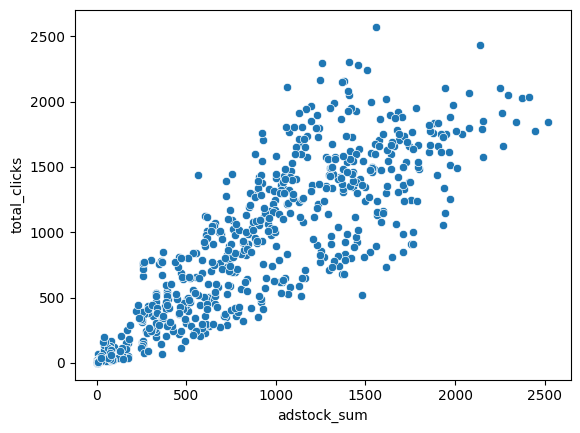

In [451]:
sns.scatterplot(data = lasso_pipe_df_2, x = 'adstock_sum', y = 'total_clicks')

# Ridge

In [452]:
ridge_pipeline = Pipeline([
    ('union', union),
    ('ridge', ridge)
])

ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                   Pipeline(steps=[('add_holidays',
                                                                                                                    AddHolidaysTransformer())]),
                                                                                                   ['day']),
                                                                                                  ('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day'])]))])),
                                                ('adstock_pipeline',
                                                 Pipeline(...
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['facebook']),
                                                                                                  ('google_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['google']),
                                                                                                  ('tiktok_pipe',
                                                                                                   Pipeline(steps=[('carryover',
                                                                                                                    ExponentialCarryover()),
                                                                                                                   ('saturation',
                                                                                                                    BoxCoxSaturation())]),
                                                                                                   ['tiktok'])]))]))])),
                ('ridge', Ridge(alpha=0.1))])

In [453]:
ridge_pipe_df = pd.DataFrame(ridge_pipeline[0].transform(X_train))
ridge_pipe_df.columns = ['holiday','weekend', 'adstock_fb', 'adstock_gg', 'adstock_tt']
ridge_pipe_df['adstock_sum'] = ridge_pipe_df['adstock_fb'] + ridge_pipe_df['adstock_gg'] + ridge_pipe_df['adstock_tt']
ridge_pipe_df['day'] = train_df.index
ridge_pipe_df.set_index('day', inplace=True)
ridge_pipe_df_2 = ridge_pipe_df.copy()
ridge_pipe_df_2['total_clicks'] = train_df['total_clicks']
ridge_pipe_df_2

,holiday,weekend,adstock_fb,adstock_gg,adstock_tt,adstock_sum,total_clicks
day,,,,,,,
2021-07-01,0.0,0.0,257.01,1.17,0.00,258.18,149.0
2021-07-02,0.0,1.0,250.30,0.84,0.00,251.14,157.0
2021-07-03,0.0,1.0,248.59,0.72,0.00,249.31,135.0
2021-07-04,0.0,0.0,258.05,0.07,0.00,258.12,124.0
2021-07-05,0.0,0.0,257.47,0.38,0.00,257.85,158.0
...,...,...,...,...,...,...,...
2023-04-12,0.0,0.0,885.33,208.52,209.03,1302.88,1430.0
2023-04-13,0.0,0.0,882.17,186.47,208.82,1277.46,1337.0
2023-04-14,0.0,1.0,662.08,160.69,216.38,1039.15,1101.0


## Score

In [454]:
y_pred = ridge_pipeline.predict(X_train)
y_true = y_train

ridge_rmse = mean_squared_error(y_true, y_pred, squared = False)
ridge_mse = mean_squared_error(y_true, y_pred, squared = True)
ridge_mae = mean_absolute_error(y_true, y_pred)

f"MAE: {ridge_mae}, RMSE: {ridge_rmse}, MSE: {ridge_mse}"

'MAE: 168.4198768317718, RMSE: 228.3163709313679, MSE: 52128.36523526998'

<Axes: xlabel='adstock_sum', ylabel='total_clicks'>

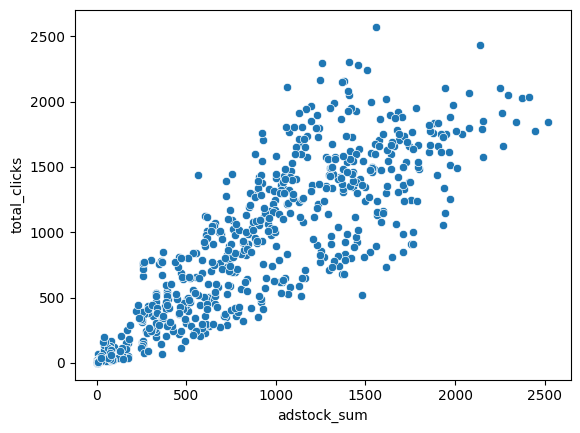

In [455]:
sns.scatterplot(data = ridge_pipe_df_2, x = 'adstock_sum', y = 'total_clicks')

# Elastic Net

In [456]:
enet_pipeline = Pipeline([
    ('union', union),
    ('enet', enet)
])

grid = {
    'enet__alpha': [0.01, 0.1, 0.5, 1], 
    'enet__l1_ratio': [0.2, 0.5, 0.75, 0.8, 0.95]}

search = GridSearchCV(
    enet_pipeline,
    grid, 
    cv = tscv,
    n_jobs=-1 # parallelize computation
) 

# Fit data to Grid Search
search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('time_preprocessing',
                                                                        Pipeline(steps=[('time_features',
                                                                                         ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                                          Pipeline(steps=[('add_holidays',
                                                                                                                                           AddHolidaysTransformer())]),
                                                                                                                          ['day']),
                                                                                                                         ('weekends_pipe',
                                                                                                                          Pipeline(...
                                                                                                                         ('google_pipe',
                                                                                                                          Pipeline(steps=[('carryover',
                                                                                                                                           ExponentialCarryover()),
                                                                                                                                          ('saturation',
                                                                                                                                           BoxCoxSaturation())]),
                                                                                                                          ['google']),
                                                                                                                         ('tiktok_pipe',
                                                                                                                          Pipeline(steps=[('carryover',
                                                                                                                                           ExponentialCarryover()),
                                                                                                                                          ('saturation',
                                                                                                                                           BoxCoxSaturation())]),
                                                                                                                          ['tiktok'])]))]))])),
                                       ('enet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'enet__alpha': [0.01, 0.1, 0.5, 1],
                         'enet__l1_ratio': [0.2, 0.5, 0.75, 0.8, 0.95]})

In [457]:
best_pipeline.fit(X_train, y_train)
best_pipeline = search.best_estimator_
best_pipeline.named_steps['enet'].intercept_

138.31883800839603

In [458]:
features = ['holiday', 'weekend', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pd.Series(
    best_pipeline.named_steps['enet'].coef_,
    index=features
)

holiday        0.000000
weekend      -64.255960
adstock_fb     0.573145
adstock_gg    -0.450835
adstock_tt     2.398401
dtype: float64

In [459]:
y_pred = best_pipeline.predict(X_train)
y_true = y_train

enet_rmse = mean_squared_error(y_true, y_pred, squared = False)
enet_mse = mean_squared_error(y_true, y_pred, squared = True)
enet_mae = mean_absolute_error(y_true, y_pred)

f"MAE: {enet_mae}, RMSE: {enet_rmse}, MSE: {enet_mse}"

'MAE: 168.5223105296124, RMSE: 228.54417508318352, MSE: 52232.43996445284'

# Results

In [460]:

results = {'linear': [mae, rmse, mse],
 'forest': [forest_mae, forest_rmse, forest_mse],
 'lasso': [lasso_mae, lasso_rmse, lasso_mse],
 'ridge': [ridge_mae, ridge_rmse, ridge_mse],
 'enet': [enet_mae, enet_rmse, enet_mse]
}

In [461]:
results_df = pd.DataFrame(results).transpose()
results_df.columns = ['mae', 'rmse','mse']
results_df

,mae,rmse,mse
linear,168.420510,228.316369,52128.364154
forest,45.886046,66.357900,4403.370910
lasso,168.402262,228.317038,52128.669888
ridge,168.419877,228.316371,52128.365235
enet,168.522311,228.544175,52232.439964


In [462]:
y_train.describe()

count     655.000000
mean      897.338931
std       615.801691
min         0.000000
25%       359.000000
50%       852.000000
75%      1405.500000
max      2574.000000
Name: total_clicks, dtype: float64

In [463]:
df_ = lasso_pipe_df_2.copy()
df_ = df_.drop(columns = ['total_clicks', 'adstock_sum'])
df_.columns

Index(['holiday', 'weekend', 'adstock_fb', 'adstock_gg', 'adstock_tt'], dtype='object')

In [464]:
x = ridge_pipe_df_2.copy()
x = x.drop(columns = 'adstock_sum')
x

,holiday,weekend,adstock_fb,adstock_gg,adstock_tt,total_clicks
day,,,,,,
2021-07-01,0.0,0.0,257.01,1.17,0.00,149.0
2021-07-02,0.0,1.0,250.30,0.84,0.00,157.0
2021-07-03,0.0,1.0,248.59,0.72,0.00,135.0
2021-07-04,0.0,0.0,258.05,0.07,0.00,124.0
2021-07-05,0.0,0.0,257.47,0.38,0.00,158.0
...,...,...,...,...,...,...
2023-04-12,0.0,0.0,885.33,208.52,209.03,1430.0
2023-04-13,0.0,0.0,882.17,186.47,208.82,1337.0
2023-04-14,0.0,1.0,662.08,160.69,216.38,1101.0


# OLS

In [465]:
model = smf.ols(formula='total_clicks ~ holiday+weekend+adstock_fb+adstock_gg+adstock_tt', data=x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_clicks   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     813.0
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          1.28e-276
Time:                        12:01:01   Log-Likelihood:                -4486.5
No. Observations:                 655   AIC:                             8985.
Df Residuals:                     649   BIC:                             9012.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    143.2966     17.547      8.166      0.000     108.841     177.753
holiday       22.1767     46.170      0.480      0.631     -68.484     112.837
weekend      -84.4159     19.925     -4.237      0.000    -123.542     -45.290
adstock_fb     0.5730      0.023     24.485      0.000       0.527       0.619
adstock_gg    -0.4656      0.127     -3.655      0.000      -0.716      -0.216
adstock_tt     2.4046      0.064     37.625      0.000       2.279       2.530
==============================================================================
Omnibus:                       61.132   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.187
Skew:                           0.348   Prob(JB):                     1.04e-50
Kurtosis:                       5.819   Cond. No.                     4.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [466]:
model.pvalues[1:]

holiday        6.311556e-01
weekend        2.597613e-05
adstock_fb     2.813923e-94
adstock_gg     2.775766e-04
adstock_tt    3.058973e-165
dtype: float64

In [467]:
coefs = pd.DataFrame({
    "coef_linreg": pd.Series(pipeline[-1].coef_, index = df_.columns),
    "coef_ridge": pd.Series(ridge_pipeline[-1].coef_, index = df_.columns),
    "coef_lasso": pd.Series(lasso_pipeline[-1].coef_, index= df_.columns)})\

coefs\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: black')

,coef_linreg,coef_ridge,coef_lasso
holiday,22,22,19
weekend,-84,-84,-83
adstock_fb,0,0,0
adstock_gg,0,0,0
adstock_tt,2,2,2


In [468]:
coefs['pvalues'] = model.pvalues[1:]

# Coefficients

In [469]:
coefs

,coef_linreg,coef_ridge,coef_lasso,pvalues
holiday,22.176723,22.093157,19.568515,6.311556e-01
weekend,-84.415939,-84.353841,-83.967600,2.597613e-05
adstock_fb,0.572986,0.572987,0.572994,2.813923e-94
adstock_gg,-0.465646,-0.465600,-0.465085,2.775766e-04
adstock_tt,2.404603,2.404582,2.404183,3.058973e-165


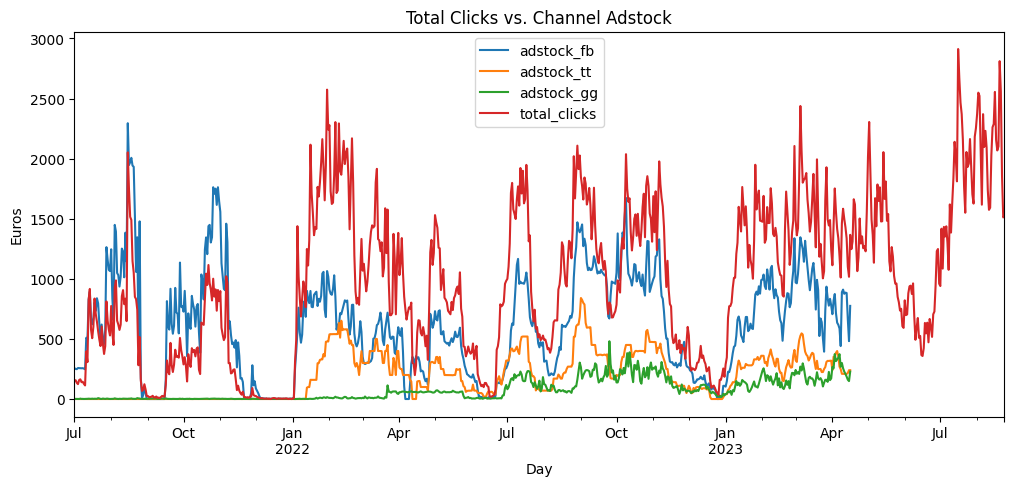

In [470]:
title = 'Total Clicks vs. Channel Adstock'
ylabel= 'Euros'
xlabel= ''

ax = pipe_df['adstock_fb'].plot(figsize=(12,5),title=title,legend=True)
ax = pipe_df['adstock_tt'].plot(figsize=(12,5),title=title,legend=True)
ax = pipe_df['adstock_gg'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['total_clicks'].plot(legend=True);

# Response

In [471]:
# 1. predict clicks as a result of channel spending

# 2. see how clicks influence sales